# Analyzing the Capacity of SOMs to clear outliers

In this notebook, we're going to analyze how SOms can identify outliers in the dataset and then, reduce the rate of the false alarms.

In [17]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from modules.som_detector import SOM_outlier_detector
from modules.anomaly_detector import AnomalyDetectionKit

# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
x = pd.read_csv('../0_data/som_studies/normal_operation_compressor.csv',
                index_col=[0])
x.head()

,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,PIT-529D,PIT-530D,...,XT-506D-X,XT-506D-Y,XT-507D-X,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D
0,45.493362,40.756344,20.902378,17.372452,2.038123,2.224318,0.992395,3.347148,4.506837,5.060158,...,13.370263,11.907991,8.478170,9.437210,6.986217,10.068040,26.280346,26.706827,0.071125,26.317259
1,44.839832,40.872658,20.552832,17.094263,2.000226,2.184674,0.992454,3.304876,4.491679,5.077046,...,13.718800,12.062502,8.429724,9.592444,7.121663,10.251029,26.943079,27.212057,0.071125,26.810747
2,47.116543,40.626442,21.869236,18.119350,2.124781,2.319191,0.991775,3.460335,4.479621,5.148957,...,13.031363,11.878652,8.444281,9.146814,6.753309,9.941579,24.002470,24.779950,0.074429,24.078333
3,47.255856,40.635143,21.998035,18.240286,2.147179,2.343245,0.991836,3.480938,4.429873,5.161973,...,13.584080,12.130912,8.444281,9.146688,6.811512,10.018728,23.825638,24.554980,0.075468,23.965624
4,47.097378,40.642517,21.893854,18.163750,2.138274,2.335860,0.991764,3.471886,4.563508,5.125422,...,13.545857,12.169901,8.458838,9.292214,6.772871,10.038246,23.996452,24.678562,0.071191,24.140740


In [3]:
# apply classical anomaly detection (simple PCA)
adk = AnomalyDetectionKit()

# do parallel analysis
adk.parallel_analysis(x)

Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %


In [4]:
# fit the final PCA
adk.fit_final(x)

# calculate T2s and SPEs
t2s, tmax = adk.calculate_T2(data=x)
spe, spe_max = adk.calculate_SPE(data=x)

# create analysis dataframe
data = x.copy()
data['t2'] = t2s
data['spe'] = spe

# calculate baseline metrics
adk.calculate_metrics(data_stats=data[['t2', 'spe']], limits=[tmax, spe_max])

(0.08635996771589992, 0.1560398170567662, 0.026903416733925208)

Now, after applying the first PCA, let's use the SOM to detect outliers. In this case, SOM will use the statistics T2 and SPE as inputs.

In [5]:
# create and fit som
som = SOM_outlier_detector()
som.fit_som(x=data[['t2', 'spe']], n=2)

In [6]:
# calculate distances
data['dist'] = som.average_distances(data[['t2', 'spe']])
data.head()

,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,PIT-529D,PIT-530D,...,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D,t2,spe,dist
0,45.493362,40.756344,20.902378,17.372452,2.038123,2.224318,0.992395,3.347148,4.506837,5.060158,...,9.437210,6.986217,10.068040,26.280346,26.706827,0.071125,26.317259,15.304634,5.927580,0.704781
1,44.839832,40.872658,20.552832,17.094263,2.000226,2.184674,0.992454,3.304876,4.491679,5.077046,...,9.592444,7.121663,10.251029,26.943079,27.212057,0.071125,26.810747,15.945228,6.908700,0.704781
2,47.116543,40.626442,21.869236,18.119350,2.124781,2.319191,0.991775,3.460335,4.479621,5.148957,...,9.146814,6.753309,9.941579,24.002470,24.779950,0.074429,24.078333,18.024413,5.310536,1.000000
3,47.255856,40.635143,21.998035,18.240286,2.147179,2.343245,0.991836,3.480938,4.429873,5.161973,...,9.146688,6.811512,10.018728,23.825638,24.554980,0.075468,23.965624,20.725690,4.206950,1.000000
4,47.097378,40.642517,21.893854,18.163750,2.138274,2.335860,0.991764,3.471886,4.563508,5.125422,...,9.292214,6.772871,10.038246,23.996452,24.678562,0.071191,24.140740,19.876844,3.748764,1.000000


Apparently, each time SOMs are run, they return a different result of average distance. This is because their initialization are random. We need to simulate many times and understand if there is some type of distance stabilization.

This is necessary because if we rely on a single run, we may eliminate values that are not outliers, simply because they might had the bad luck to be assigned to a different neuron. In addition, we need to establish a minimum value of iterations so the majority of measurements readings are stabilized.

In this study, we'll consider a stabilization when the moving coefficient of variation of the cumulated mean is lower than 1 %.

In [7]:
# test minimum N for convergence
n_test = np.arange(6, 51, 1)
conv_curve = []
N_curves = 50

for _ in range(N_curves):
    avg_convergence = []
    for n in n_test:
        avg_convergence.append(som.convergence_analysis(x=data[['t2', 'spe']], n=n, n_soms=2, eps=0.01))
    conv_curve.append(avg_convergence)

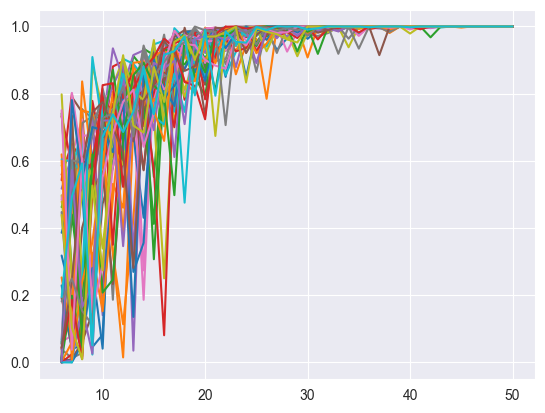

In [8]:
# plot each curve
for i in range(N_curves):
    plt.plot(n_test, conv_curve[i])

In [ ]:
# create dataframe and calculate statistics
conv_curve = pd.DataFrame(np.array(conv_curve).T,
                          columns=[f'Run{i+1}' for i in range(N_curves)])

t = sts.t.ppf(q=0.975, df=N_curves-1)
stats_cols = [c for c in conv_curve.columns if c.find('Run') != -1]

In [13]:
conv_curve['avg'] = conv_curve[stats_cols].mean(axis=1)
conv_curve['se'] = t * np.sqrt((conv_curve['avg'] * (1-conv_curve['avg'])) / N_curves)
conv_curve.head()

,Run1,Run2,Run3,Run4,Run5,Run6,Run7,Run8,Run9,Run10,...,Run44,Run45,Run46,Run47,Run48,Run49,Run50,avg,std,se
0,0.318267,0.478343,0.462470,0.559053,0.517353,0.000000,0.062416,0.038741,0.497444,0.038472,...,0.042776,0.004574,0.043853,0.750874,0.182136,0.439064,0.194781,0.244751,0.265026,0.122187
1,0.191283,0.412429,0.557170,0.651601,0.613398,0.010761,0.079096,0.012645,0.080172,0.490449,...,0.186441,0.572505,0.242400,0.038203,0.249933,0.103578,0.493140,0.343293,0.273991,0.134939
2,0.062685,0.754372,0.497982,0.594566,0.237019,0.059995,0.026634,0.028787,0.252623,0.559591,...,0.010223,0.164918,0.585418,0.608017,0.153888,0.009416,0.592682,0.360285,0.273484,0.136438
3,0.605865,0.278719,0.691956,0.746570,0.597525,0.148776,0.740382,0.739037,0.579500,0.535109,...,0.503632,0.231100,0.744418,0.171106,0.111111,0.526500,0.051116,0.478273,0.257707,0.141964
4,0.687382,0.649179,0.758407,0.184557,0.730428,0.472693,0.703793,0.652677,0.798224,0.737961,...,0.825397,0.719935,0.775087,0.551520,0.727468,0.273877,0.671509,0.593468,0.222258,0.139594


In [10]:
# check lasts results
conv_curve.tail().T

,40,41,42,43,44
Run1,1.0,1.0,1.0,1.0,1.000000
Run2,1.0,1.0,1.0,1.0,1.000000
Run3,1.0,1.0,1.0,1.0,1.000000
Run4,1.0,1.0,1.0,1.0,1.000000
Run5,1.0,1.0,1.0,1.0,1.000000
Run6,1.0,1.0,1.0,1.0,1.000000
Run7,1.0,1.0,1.0,1.0,1.000000
Run8,1.0,1.0,1.0,1.0,1.000000
Run9,1.0,1.0,1.0,1.0,1.000000
Run10,1.0,1.0,1.0,1.0,1.000000


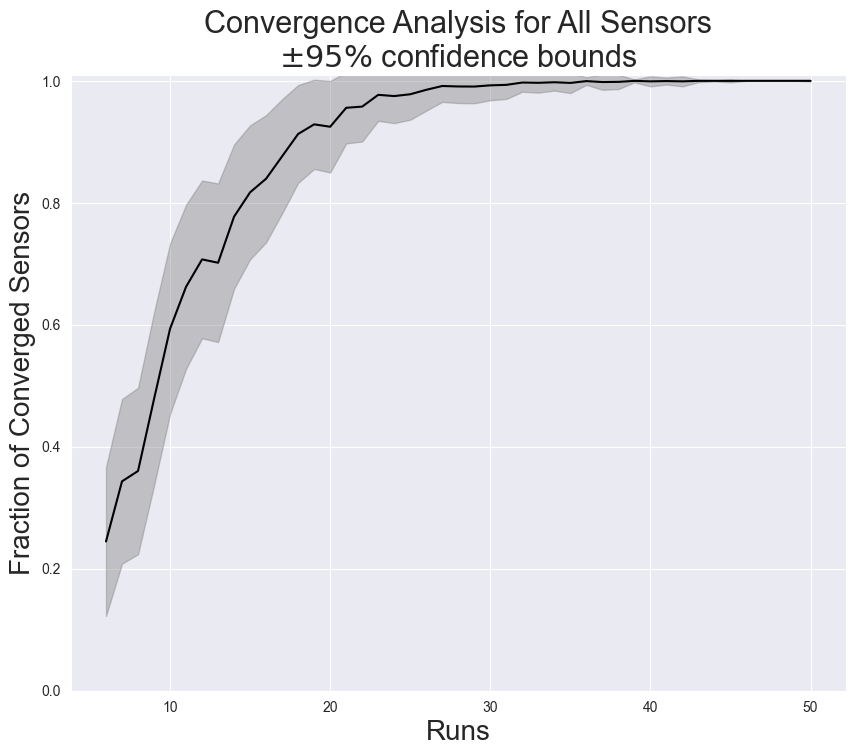

In [14]:
# create a plot
plt.figure(figsize=(10, 8))
plt.plot(n_test, conv_curve['avg'], 'k-')
plt.fill_between(n_test, 
                 conv_curve['avg'] - conv_curve['se'],
                 conv_curve['avg'] + conv_curve['se'],
                 color='gray',
                 alpha=.4)
plt.ylim([0, 1.01])
plt.xlabel('Runs', size=20)
plt.ylabel('Fraction of Converged Sensors', size=20)
plt.title('Convergence Analysis for All Sensors\n' + r'$\pm 95 \%$ confidence bounds', size=22)
plt.savefig('../8_imgs/som_studies/convergence_analysis.png', dpi=300, bbox_inches='tight')


We see that 40 iterations are enough to ensure the stabilization of all sensor readings for this dataset. Now, we should proceed with the sequential fittings of SOMs to determine the true AID for each sensor reading.

In [24]:
# define empty AID vector
aid = []
N = 40      # minimum iterations for sensor readings convergence
for _ in range(N):
    # fit soms
    som.fit_som(x=data[['t2', 'spe']], n=2)

    # calculate aids
    aid.append(som.average_distances(x=data[['t2', 'spe']]).values)

# concatenate all aids
final_aids = np.concatenate(aid, axis=1)

# calculate average for all sensor readings
data['avg_aid'] = np.mean(final_aids, axis=1)
data.head()

,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,PIT-529D,PIT-530D,...,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D,t2,spe,avg_aid
0,45.493362,40.756344,20.902378,17.372452,2.038123,2.224318,0.992395,3.347148,4.506837,5.060158,...,9.437210,6.986217,10.068040,26.280346,26.706827,0.071125,26.317259,15.304634,5.927580,0.771579
1,44.839832,40.872658,20.552832,17.094263,2.000226,2.184674,0.992454,3.304876,4.491679,5.077046,...,9.592444,7.121663,10.251029,26.943079,27.212057,0.071125,26.810747,15.945228,6.908700,0.836732
2,47.116543,40.626442,21.869236,18.119350,2.124781,2.319191,0.991775,3.460335,4.479621,5.148957,...,9.146814,6.753309,9.941579,24.002470,24.779950,0.074429,24.078333,18.024413,5.310536,0.945174
3,47.255856,40.635143,21.998035,18.240286,2.147179,2.343245,0.991836,3.480938,4.429873,5.161973,...,9.146688,6.811512,10.018728,23.825638,24.554980,0.075468,23.965624,20.725690,4.206950,0.977076
4,47.097378,40.642517,21.893854,18.163750,2.138274,2.335860,0.991764,3.471886,4.563508,5.125422,...,9.292214,6.772871,10.038246,23.996452,24.678562,0.071191,24.140740,19.876844,3.748764,0.945174


<Figure size 1000x1000 with 0 Axes>

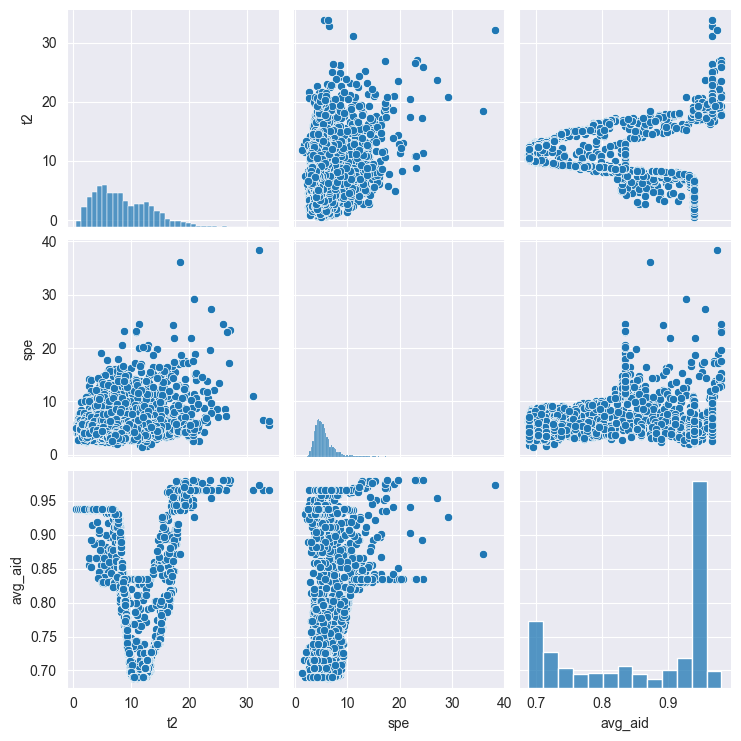

In [18]:
# maybe there is a correlation between multivariate statistics and avg_aid?
plt.figure(figsize=(10, 10))
sns.pairplot(data[['t2', 'spe', 'avg_aid']])
plt.show()

In [51]:
# Hypothesis: if we remove points based on a minimum distance, can we improve the results of false positives?
if 'dist' in data.columns:
    data.drop(['dist'], axis=1, inplace=True)


# create arrays
aid_thresh = np.linspace(1, 0.8, 100)
fp_t2_list = []
fp_spe_list = []
fp_both_list = []
explained_var = []
n_components = []
tmax_list = []
spe_max_list = []
rows = []

for t in aid_thresh:

    # make a copy
    data_test = data.copy()

    # select points based on minimum distance
    data_test = data_test.loc[data_test['avg_aid'] < t, :]

    # append rows
    rows.append(data_test.shape[0] / data.shape[0])

    # apply classical anomaly detection (simple PCA)
    adk = AnomalyDetectionKit()

    # select only process variables
    x = data_test.drop(['t2', 'spe', 'avg_aid'], axis=1)

    # do parallel analysis
    adk.parallel_analysis(x)

    # fit the final PCA
    adk.fit_final(x, n=8)

    # append explained variance of PCA and n components
    explained_var.append(adk.final_pca['pca'].explained_variance_ratio_.sum())
    n_components.append(adk.final_pca['pca'].explained_variance_ratio_.shape[0])

    # calculate T2s and SPEs
    t2s, tmax = adk.calculate_T2(data=x)
    spe, spe_max = adk.calculate_SPE(data=x)

    # create analysis dataframe
    data_test['t2'] = t2s
    data_test['spe'] = spe

    # calculate baseline metrics
    fp_t2, fp_spe, fp_both = adk.calculate_metrics(data_stats=data_test[['t2', 'spe']], limits=[tmax, spe_max])

    # append stats
    fp_t2_list.append(fp_t2)
    fp_spe_list.append(fp_spe)
    fp_both_list.append(fp_both)
    tmax_list.append(tmax)
    spe_max_list.append(spe_max)

Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %
Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %
Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %
Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %
Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %
Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %
Parallel Method Results
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 87.11 %
Parallel Method Results
--------------------------------------------------
Number of PCs retained

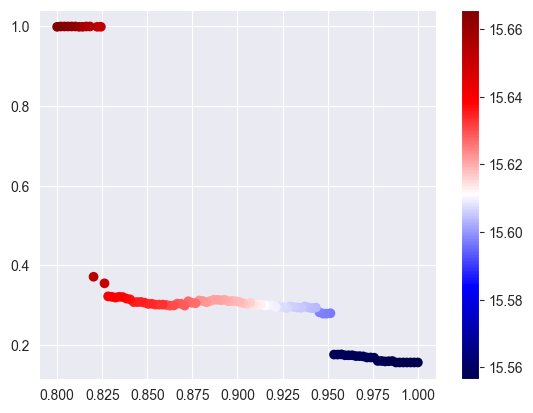

In [70]:
# plt.plot(aid_thresh, fp_both_list)
# plt.plot(aid_thresh, fp_t2_list)
plt.scatter(x=aid_thresh, y=fp_spe_list, c=tmax_list, cmap='seismic')
plt.colorbar()